# Portfolio factors with dimensional reduction and online learning

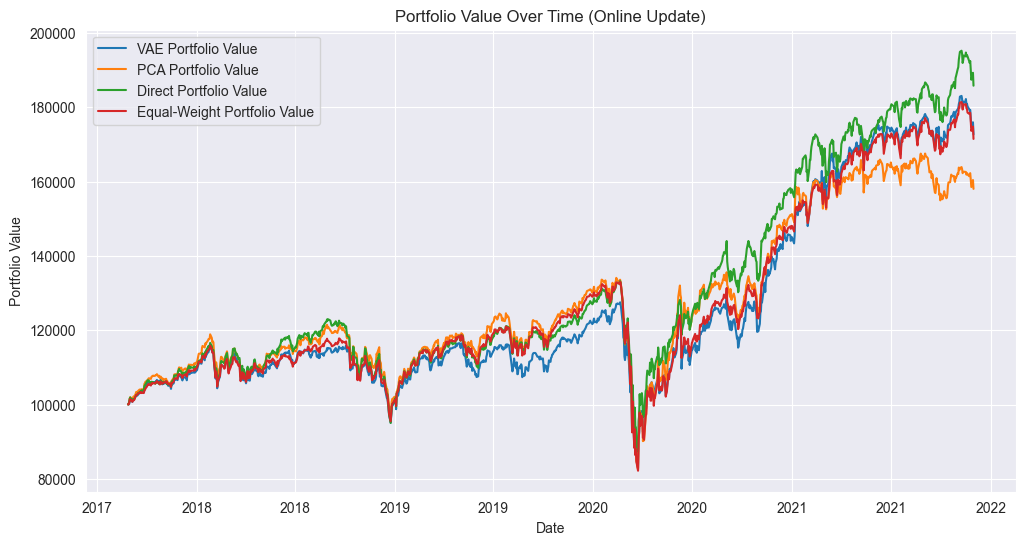

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.dates import DateFormatter

# Step 1: Data Preparation
project_root = '/Users/home/Work/Projects/nisca'
os.chdir(project_root)

data = pd.read_csv('datasets/Yahoo/ETF_prices.csv')
data = data[['price_date', 'adj_close', 'fund_symbol']]
data = data.sort_values(by=['fund_symbol', 'price_date'])
data['return'] = data.groupby('fund_symbol')['adj_close'].pct_change()

data_pivot = data.pivot(index='price_date', columns='fund_symbol', values='return')
data_pivot_cleaned = data_pivot.dropna(axis=1, how='all')
data_pivot_cleaned = data_pivot_cleaned.dropna(axis=0, how='all')

threshold = int(0.01 * data_pivot_cleaned.shape[1])
data_pivot_cleaned = data_pivot_cleaned.dropna(thresh=threshold, axis=0)

threshold_columns = int(1 * data_pivot_cleaned.shape[0])
returns_matrix = data_pivot_cleaned.dropna(thresh=threshold_columns, axis=1)

Y = returns_matrix.values  # Shape: [T, M]
dates = pd.to_datetime(returns_matrix.index)
funds = returns_matrix.columns
T, M = Y.shape

# Split the data: 80% for training, 20% for testing and simulation
split_index = int(0.8 * T)
Y_train = Y[:split_index]  # Training set (first 80% of data)
Y_test = Y[split_index:]  # Test set (remaining 20% of data)
dates_train = dates[:split_index]
dates_test = dates[split_index:]

# Convert Y_train and Y_test to PyTorch tensors
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Step 2: Define the VAE Model (Encoder)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, y_t):
        h = torch.relu(self.fc1(y_t))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Initialize encoder, optimizer, and basis matrix A
N = 5  # Number of latent factors
hidden_dim = 512
encoder = Encoder(input_dim=M, hidden_dim=hidden_dim, latent_dim=N)

A = nn.Parameter(torch.rand(M, N, dtype=torch.float32))
optimizer = optim.Adam(list(encoder.parameters()) + [A], lr=0.001)

# Step 3: Pretrain the VAE on the First 80% of Data
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for t in range(Y_train_tensor.shape[0]):
        y_t = Y_train_tensor[t]
        mu, logvar = encoder(y_t)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_t = mu + std * eps
        s_t = torch.softmax(z_t, dim=0)

        y_hat = torch.matmul(A, s_t)
        recon_loss = nn.MSELoss()(y_hat, y_t)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss * 1e-4

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            A.copy_(A.clamp(min=0))

# Store the learned latent factors and basis matrix after pretraining
s_t_array = np.array([encoder(Y_train_tensor[i])[0].detach().numpy() for i in range(Y_train_tensor.shape[0])])
A_trained = A.detach().numpy()

# Step 4: PCA Baseline for Comparison
pca = PCA(n_components=N)
pca.fit(Y_train)
components_pca = pca.components_.T
scores_pca = pca.transform(Y_train)

# Step 5: Direct Optimization without PCA or VAE
expected_returns_direct = Y_train.mean(axis=0)

# Optimization problem for direct approach
w_direct_var = cp.Variable(M)
constraints_direct = [cp.sum(w_direct_var) == 1, w_direct_var >= 0, w_direct_var <= 0.1]
objective_direct = cp.Maximize(expected_returns_direct @ w_direct_var)
prob_direct = cp.Problem(objective_direct, constraints_direct)
prob_direct.solve()
optimal_weights_direct = w_direct_var.value

# Step 6: Constant Equal Weight Portfolio
equal_weights = np.ones(M) / M

# Step 7: Online Portfolio Learning and Simulation (VAE, PCA, Direct Optimization)
initial_investment = 100000
portfolio_value_vae = [initial_investment]
portfolio_value_pca = [initial_investment]
portfolio_value_direct = [initial_investment]
portfolio_value_constant = [initial_investment]

transaction_costs = 0.001  # 0.1% per transaction

holdings_vae = initial_investment * optimal_weights_direct  # Start with direct weights (can be pretrained VAE weights)
holdings_pca = initial_investment * optimal_weights_direct
holdings_direct = initial_investment * optimal_weights_direct
holdings_constant = initial_investment * equal_weights

for t in range(Y_test.shape[0]):
    y_t_new = Y_test_tensor[t]

    # ---- VAE Online Update ----
    mu_new, logvar_new = encoder(y_t_new)
    std_new = torch.exp(0.5 * logvar_new)
    eps_new = torch.randn_like(std_new)
    z_t_new = mu_new + std_new * eps_new
    s_t_new = torch.softmax(z_t_new, dim=0)

    y_hat_new = torch.matmul(A, s_t_new)
    recon_loss_new = nn.MSELoss()(y_hat_new, y_t_new)
    kld_loss_new = -0.5 * torch.sum(1 + logvar_new - mu_new.pow(2) - logvar_new.exp())
    loss_new = recon_loss_new + kld_loss_new * 1e-4

    optimizer.zero_grad()
    loss_new.backward()
    optimizer.step()

    with torch.no_grad():
        A.copy_(A.clamp(min=0))

    expected_factor_returns_vae_new = s_t_new.detach().numpy()
    expected_returns_vae_new = A.detach().numpy() @ expected_factor_returns_vae_new

    # VAE Portfolio Rebalance
    prob_vae = cp.Problem(cp.Maximize(expected_returns_vae_new @ w_direct_var), constraints_direct)
    prob_vae.solve()
    w_vae = w_direct_var.value
    holdings_vae = np.sum(holdings_vae * (1 + Y_test[t])) * w_vae

    # PCA Portfolio Rebalance
    scores_pca_new = pca.transform(y_t_new.unsqueeze(0).numpy())
    expected_returns_pca_new = components_pca @ scores_pca_new.flatten()
    prob_pca = cp.Problem(cp.Maximize(expected_returns_pca_new @ w_direct_var), constraints_direct)
    prob_pca.solve()
    w_pca = w_direct_var.value
    holdings_pca = np.sum(holdings_pca * (1 + Y_test[t])) * w_pca

    # Direct Optimization Portfolio Rebalance
    expected_returns_direct_new = Y_test[:t+1].mean(axis=0)
    prob_direct = cp.Problem(cp.Maximize(expected_returns_direct_new @ w_direct_var), constraints_direct)
    prob_direct.solve()
    holdings_direct = np.sum(holdings_direct * (1 + Y_test[t])) * w_direct_var.value

    # Constant Portfolio (no rebalancing)
    holdings_constant = np.sum(holdings_constant * (1 + Y_test[t])) * equal_weights

    # Track portfolio values
    portfolio_value_vae.append(np.sum(holdings_vae))
    portfolio_value_pca.append(np.sum(holdings_pca))
    portfolio_value_direct.append(np.sum(holdings_direct))
    portfolio_value_constant.append(np.sum(holdings_constant))

# Step 8: Plot Portfolio Values Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates_test, portfolio_value_vae[1:], label='VAE Portfolio Value')
plt.plot(dates_test, portfolio_value_pca[1:], label='PCA Portfolio Value')
plt.plot(dates_test, portfolio_value_direct[1:], label='Direct Portfolio Value')
plt.plot(dates_test, portfolio_value_constant[1:], label='Equal-Weight Portfolio Value')
plt.title('Portfolio Value Over Time (Online Update)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

# Format the x-axis with years
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Use Y_train for reconstruction evaluation if applicable
Y_hat_train = s_t_array @ A_trained.T  # Shape: [T_train, M]
mse_train = mean_squared_error(Y_train.flatten(), Y_hat_train.flatten())
print(f'Reconstruction MSE (VAE, Train Set): {mse_train:.6f}')

# Calculate explained variance ratio on training data
total_variance_train = np.var(Y_train, ddof=1)
residuals_train = Y_train - Y_hat_train
residual_variance_train = np.var(residuals_train, ddof=1)
explained_variance_ratio_train = 1 - (residual_variance_train / total_variance_train)
print(f'Explained Variance Ratio (VAE, Train Set): {explained_variance_ratio_train:.4f}')

# PCA reconstruction and explained variance on the full data Y
from sklearn.decomposition import PCA

pca = PCA(n_components=N)
pca.fit(Y_train)
Y_pca_train = pca.transform(Y_train)
Y_pca_reconstructed_train = pca.inverse_transform(Y_pca_train)

mse_pca_train = mean_squared_error(Y_train.flatten(), Y_pca_reconstructed_train.flatten())
explained_variance_pca_train = np.sum(pca.explained_variance_ratio_)
print(f'PCA Reconstruction MSE (Train Set): {mse_pca_train:.6f}')
print(f'PCA Explained Variance Ratio (Train Set): {explained_variance_pca_train:.4f}')

Reconstruction MSE (VAE, Train Set): 0.000210
Explained Variance Ratio (VAE, Train Set): 0.0350
PCA Reconstruction MSE (Train Set): 0.000016
PCA Explained Variance Ratio (Train Set): 0.9285


In [4]:
def calculate_performance_metrics(portfolio_values, risk_free_rate=0.0):
    import pandas as pd
    portfolio_values = pd.Series(portfolio_values)
    
    # Calculate daily returns from portfolio values
    returns = portfolio_values.pct_change().dropna()
    
    # Annualized metrics
    mean_return = returns.mean() * 252  # Annualized
    volatility = returns.std() * np.sqrt(252)  # Annualized
    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    
    # Cumulative return (final portfolio value relative to the initial)
    cumulative_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    
    # Max Drawdown: The largest peak-to-trough decline in portfolio value
    running_max = portfolio_values.cummax()
    drawdown = (portfolio_values - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Mean Return': mean_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Cumulative Return': cumulative_return,
        'Max Drawdown': max_drawdown
    }

# Calculate performance metrics for each portfolio
metrics_vae = calculate_performance_metrics(portfolio_value_vae[1:])
metrics_pca = calculate_performance_metrics(portfolio_value_pca[1:])
metrics_direct = calculate_performance_metrics(portfolio_value_direct[1:])
metrics_constant = calculate_performance_metrics(portfolio_value_constant[1:])

# Display metrics in a DataFrame
df_metrics = pd.DataFrame(
    [metrics_vae, metrics_pca, metrics_direct, metrics_constant], 
    index=['VAE Portfolio', 'PCA Portfolio', 'Direct Portfolio', 'Equal-Weight Portfolio']
)
print(df_metrics)

                        Mean Return  Volatility  Sharpe Ratio  \
VAE Portfolio              0.151623    0.215138      0.704768   
PCA Portfolio              0.131027    0.215971      0.606687   
Direct Portfolio           0.168257    0.212376      0.792262   
Equal-Weight Portfolio     0.149686    0.213405      0.701416   

                        Cumulative Return  Max Drawdown  
VAE Portfolio                    0.725963     -0.350197  
PCA Portfolio                    0.579636     -0.384289  
Direct Portfolio                 0.857125     -0.344163  
Equal-Weight Portfolio           0.713830     -0.382065  


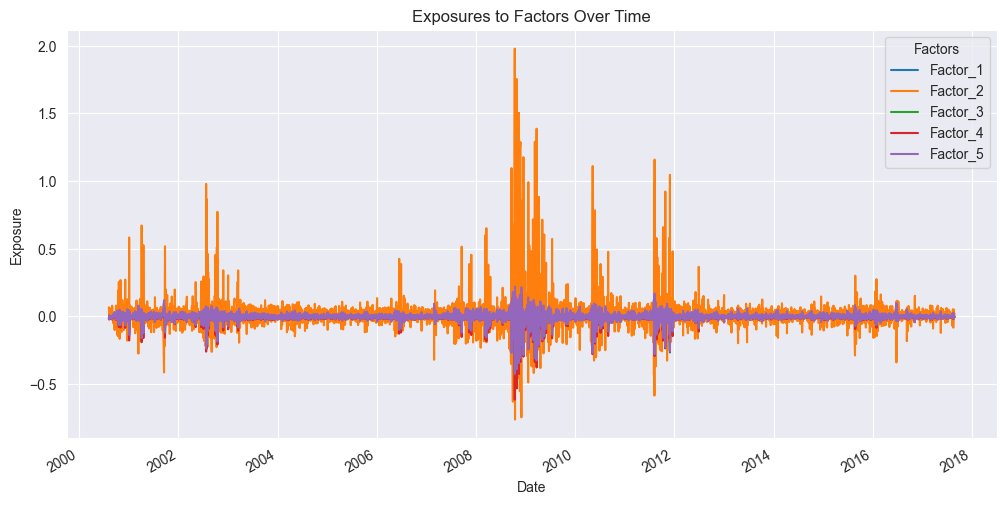

In [13]:
df_A = pd.DataFrame(A_trained, index=funds, columns=[f'Factor_{i + 1}' for i in range(N)])
df_s_t = pd.DataFrame(s_t_array, index=dates_train, columns=[f'Factor_{i + 1}' for i in range(N)])
import matplotlib.pyplot as plt
import seaborn as sns

df_s_t.plot(figsize=(12, 6))
plt.title('Exposures to Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend(title='Factors')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.show()